## Exploring Keras: Toxicity Levels 

Within this notebook, I will be following the Text classification with an RNN [tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn) by Tensorflow. The goal is to explore the basic suggested pipeline and compare the results to those produced by using the suggested classification methods suggested by spaCy (see the Main-Exploring-Spacy-Toxic-Comments-Challenge in this repo for further detail).

## The task at hand

I will be using the [Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) dataset as an example.

**The data:** A large number of Wikipedia comments which have been labeled by human raters for toxic behavior. 
The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The model should predicts the toxicity of these comments.

## Importing packages & dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv("/Users/anastasiakuzmich/Desktop/jigsaw-toxic-comment-classification-challenge/train.csv")

print("The dataset contains %s entries with %s features." 
      % (df.shape[0], df.shape[1]))

The dataset contains 159571 entries with 8 features.


## Preparing the dataset

### Dropping the columns I will not require for this task

✏️ The tutorial follows a binary classification task, so I will be doing the same to predict simply whether a comment is toxic or not:

In [3]:
df = df[["comment_text", "toxic"]]

### Basic text cleaning 

In [4]:
def clean_comments_column(df):
    
    """Cleans the comments column."""
    
    import re
    
    IpAddressRegex = "(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})"
    DateTimeRegex = "(\d{2}\:\d{2}\, [A-Z][a-z]{2,8}\ \d{1,2}\, \d{4}\ \([A-Z]{3}\))|(\d{2}\:\d{2}\, \d{2}\ [A-Z][a-z]{2}\ \d{4}\ \([A-Z]{3}\))|(\d{2}\:\d{2}\, \d{1,2}\ [A-Z][a-z]{2,8} \d{4})|(\d{1,2}\ [A-Z][a-z]{2,8}\ \d{4}\ \([A-Z]{3}\))|(\d{1,2}\ [A-Z][a-z]{1,7}\ \d{4})|(\d{2}\:\d{2}\, \d{1,2})|([A-Z][a-z]{2,8}\ \d{4}\ \([A-Z]{3}\))"
    
    features_to_remove = [IpAddressRegex,
                          DateTimeRegex,
                          '\\n', r'\\']
    
    for feature in features_to_remove:
        df["comment_text"] = df["comment_text"].replace(feature,' ', regex=True)
 
    df['comment_text'] = df['comment_text'].replace(u'\xa0', u' ')
    
    return df

In [5]:
df = clean_comments_column(df)
df.head()

,comment_text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,""" More I can't make any real suggestions on im...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Train-test split & data restructuring

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, 
                                         train_size=0.8, 
                                         random_state=13)

In [7]:
del df

### Conversion to Tensorflow dataset objects

In [15]:
train_text = train_data['comment_text'].to_numpy()
train_labels = train_data['toxic'].to_numpy().flatten()

test_text = test_data['comment_text'].to_numpy()
test_labels = test_data['toxic'].to_numpy().flatten()

train_dataset = tf.data.Dataset.from_tensor_slices((train_text,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text,test_labels))

In [17]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [16]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"Okay so no one's gonna address this? Guess that no one editing this page cares about accuracy."
label:  0


### Shuffling the data for training and creating batches of (text, label) pairs

In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [19]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Tamilnet.tv is an amazing site.  '
 b"porkchops deserve their own page, probably not their own wiki though. i have no idea why you think this would make sense in a page about the american midwest; porkchops would be kind of a tangent. anyway i just posted to say that TOW really sucks, and you guys need to clean up this page. it's got some peoples' nicknames on it and the article reads like they probably wrote it, too. there is a thread on one of the /b/'s talking about how ridiculous the first sentence is."
 b'"   Just came here to say exactly the same thing, ""Methanol Fuel"" is about the actual fuel whereas ""Methanol Economy"" is about a hypothetical economic situation and a way of structuring infrastructure etc."']

labels:  [0 0 0]


### Encoding the text using a TextVectorization layer

In [21]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2022-12-23 12:36:00.523905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [23]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   9,  30, ...,   0,   0,   0],
       [  1,   1,  92, ...,   0,   0,   0],
       [ 51, 547,  66, ...,   0,   0,   0]])

## Creating the model

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Training the model

In [30]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
1995/1995 [==============================] - 1099s 548ms/step - loss: 0.2243 - accuracy: 0.9257 - val_loss: 0.1642 - val_accuracy: 0.9354
Epoch 2/10
1995/1995 [==============================] - 1052s 527ms/step - loss: 0.1460 - accuracy: 0.9482 - val_loss: 0.1534 - val_accuracy: 0.9417
Epoch 3/10
1995/1995 [==============================] - 877s 440ms/step - loss: 0.1396 - accuracy: 0.9506 - val_loss: 0.1491 - val_accuracy: 0.9464
Epoch 4/10
1995/1995 [==============================] - 933s 468ms/step - loss: 0.1372 - accuracy: 0.9512 - val_loss: 0.1495 - val_accuracy: 0.9453
Epoch 5/10
1995/1995 [==============================] - 1029s 515ms/step - loss: 0.1354 - accuracy: 0.9514 - val_loss: 0.1486 - val_accuracy: 0.9464
Epoch 6/10
1995/1995 [==============================] - 953s 477ms/step - loss: 0.1338 - accuracy: 0.9512 - val_loss: 0.1520 - val_accuracy: 0.9458
Epoch 7/10
1995/1995 [==============================] - 942s 472ms/step - loss: 0.1324 - accuracy: 0.9512 - v

## Evaluating the model

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

499/499 [==============================] - 44s 89ms/step - loss: 0.1399 - accuracy: 0.9516
Test Loss: 0.1399342119693756
Test Accuracy: 0.9515901803970337


(0.0, 0.229130632430315)

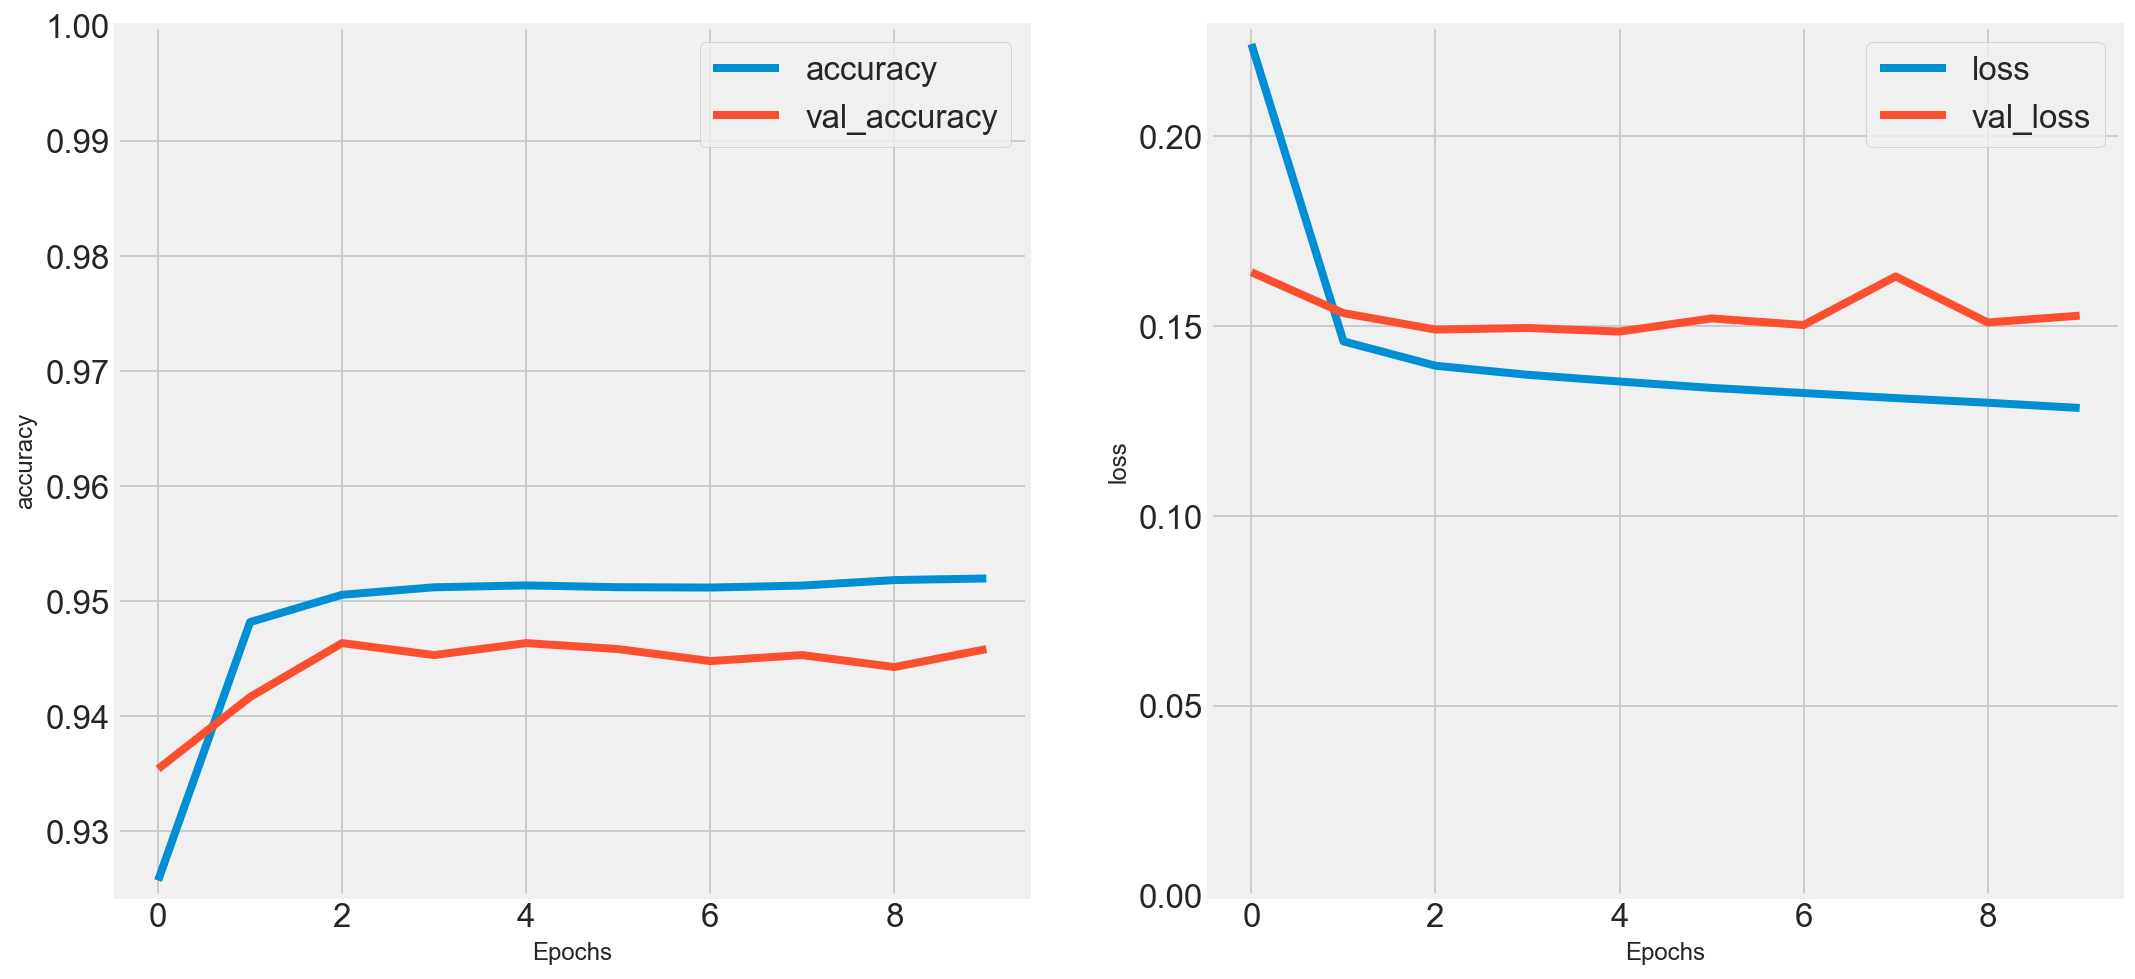

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)